# Collaborative Filterting on MovieLens Dataset

In this notebook, I'm making an attempt to "unwrap" abstaction layers of this [fast.ai lecture](http://course.fast.ai/lessons/lesson5.html) where the author is explaining how to use embeddings to build a simple recommendation system.

In other words, I'm going to directly use PyTorch framework to train a small deep learning model to predict user ratings for specific movies. The original lesson's notebook is presented [here](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb).

> **Note:** The notebook requires Python 3.6 or above. Otherwise, replace `pathlib` objects with plain paths, and interpolated strings with `format()` calls to make it compatible with the older versions of the interpreter.

---
## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [5]:
plt.style.use('ggplot')

The function below ensures that we seed all random generators with the same value to get reproducible results:

In [6]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [7]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

---
## Dataset Downloading

In the original post, the `ml-latest-small` archive with movies and users is used but there are a few other bigger datasets. You can download any of them. However, some of the datasets use different format to store the records. The function `read_data` tries to read content of the dataset if it is stored with `.csv` or `.dat` extensions.

In [8]:
def try_download(url, download_path):
    archive_name = url.split('/')[-1]
    folder_name, _ = os.path.splitext(archive_name)
    
    try:
        r = urlopen(url)
    except URLError as e:
        print('Cannot download the data. Error: %s' % s)
        return 

    assert r.status == 200
    data = r.read()

    with zipfile.ZipFile(io.BytesIO(data)) as arch:
        arch.extractall(download_path)
        
    print('The archive is extracted into folder: %s' % download_path)

In [9]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python')
            files[filename.stem] = data
    return files['ratings'], files['movies']

The following archives from the [Grouplens repository](http://files.grouplens.org/datasets/movielens) can be downloaded and read with the functions defined above:

* `ml-latest-small`
* `ml-1m`
* `ml-10m`
* `ml-20m`

In [10]:
# pick any other dataset instead
# archive_url = f'https://www.kaggle.com/datasets/aigamer/movie-lens-dataset/download?datasetVersionNumber=1'
# download_path = Path.home() / 'data' / 'movielens'

In [11]:
# try_download(archive_url, download_path)

In [12]:
# !ls -l $download_path

In [13]:
# pick one of the available folders
# ratings, movies = read_data(download_path / 'ml-1m')

In [14]:
movies = pd.read_csv("../dataset/movies.csv")
ratings = pd.read_csv("../dataset/ratings.csv")

---
## Dataset Preview

First of all, let's repeat the steps of the lecture where the dataset is loaded and prepared for further analysis.

In [15]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [16]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [18]:
tabular_preview(ratings, movies)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


---
## Dataset Preparation

Next we need a couple of helpers to prepare the data and make it ready for the training loop. The first one was already implemented in the original post:

In [19]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [20]:
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 610 users, 9724 movies
Dataset shape: (100836, 2)
Target shape: (100836,)


The second one is a small class that allows to iterate through the dataset one batch after another:

In [21]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

A convenice function `batches` allows us to split the dataset into smaller chunks during training/validation process:

In [22]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

In [23]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 224,  472],
        [ 532, 3638],
        [ 124, 4813],
        [ 262,  348]])
tensor([[3.],
        [5.],
        [2.],
        [5.]])


---
## Embeddings

In this secion we're going to create an `nn.Module` for our embedding network. The main difference from the class provided in the original post is that this class is a bit more generic: it allows to create a network of arbirary depth, with or without dropouts. Also, the `forward` method accepts an additional `minmax` argument which is expected to be a tuple with minimum and maximum values of ratings from the dataset to normalize the predicted value into specific range.

Note that to create a group of hidden layers we use a [generator](https://wiki.python.org/moin/Generators) function `gen_layers` that yields linear and dropout layers depending on values from `hidden` and `dropouts` arrays. Also note that we use the `nn.Sequence` class to group hidden layers into a single module.

In [24]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        print("Net Being Called")
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

For example, if we want to create a network with a single hidden layer and dropout, we can use the following code snippet:

In [25]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

Net Being Called


EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

If case if something more involved is required, pass a list of values instead:

In [26]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

Net Being Called


EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

---
## Cyclical Learning Rate (CLR)

One of the `fastai` library features is the cyclical learning rate scheduler. We can implement something similar inheriting the `_LRScheduler` class from the `torch` library. Following the [original paper's](https://arxiv.org/abs/1506.01186) pseudocode, this [CLR Keras callback implementation](https://github.com/bckenstler/CLR), and making a couple of adjustments to support [cosine annealing](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR) with restarts, let's create our own CLR scheduler.

The implementation of this idea is quite simple. The [base PyTorch scheduler class](https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html) has the `get_lr()` method that is invoked each time when we call the `step()` method. The method should return a list of learning rates depending on the current training epoch. In our case, we have the same learning rate for all of the layers, and therefore, we return a list with a single value. 

The next cell defines a `CyclicLR` class that expectes a single callback function. This function should accept the current training epoch and the base value of learning rate, and return a new learning rate value.

In [27]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

Our scheduler is very similar to [LambdaLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.LambdaLR) one but expects a bit different callback signature. 

So now we only need to define appropriate scheduling functions. We're createing a couple of functions that accept scheduling parameters and return a _new function_ with the appropriate signature:

In [28]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [29]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

To understand how the created functions work, and to check the correctness of our implementation, let's create a couple of plots visualizing learning rates changes depending on the number of epoch:

In [30]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

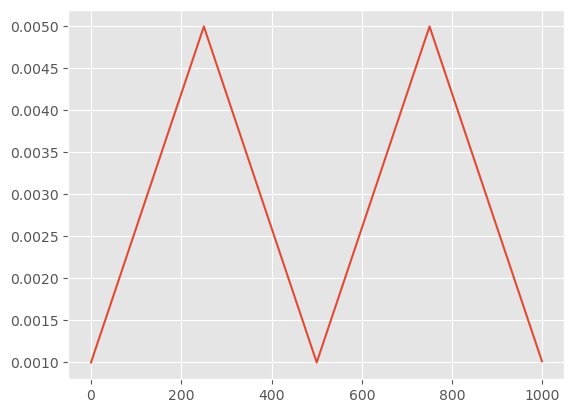

In [31]:
plot_lr(triangular(250, 0.005))

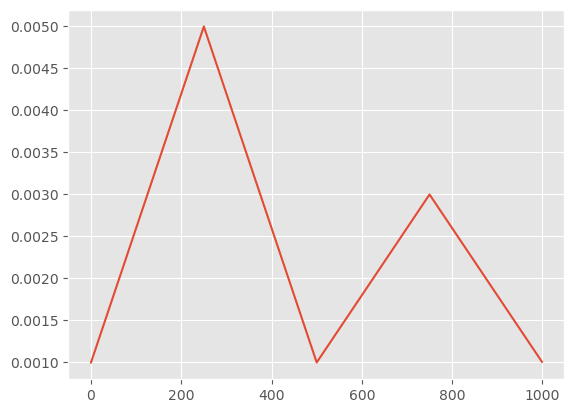

In [32]:
plot_lr(triangular(250, 0.005, 'triangular2'))

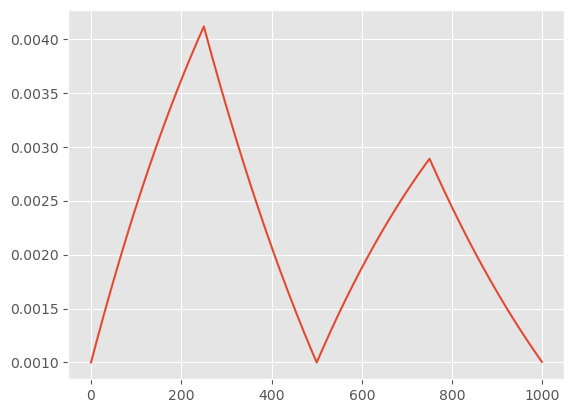

In [33]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

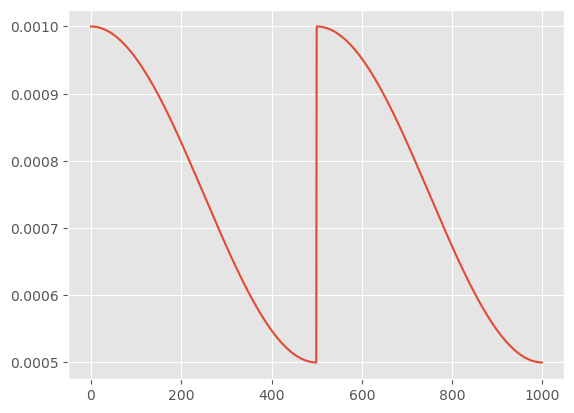

In [34]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

Note that cosine annealing scheduler is a bit different from other schedules as soon as it starts with `base_lr` and gradually decreases it to the minimal value while triangle schedulers increase the original rate.

---
## Training Loop

Now we're ready to start the training process. First of all, let's split the original dataset using [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from the `scikit-learn` library. (Though you can use anything else instead, like, [get_cv_idxs](https://github.com/fastai/fastai/blob/921777feb46f215ed2b5f5dcfcf3e6edd299ea92/fastai/dataset.py#L6-L22) from `fastai`).

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}
print(len(X_train))
print(len(X_valid))

80668
20168


In [36]:
minmax = ratings.rating.min(), ratings.rating.max()
# minmax = ratings.rating.min().astype(float), ratings.rating.max().astype(float)
minmax

(0.5, 5.0)

In [37]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

Net Being Called


The next cell is preparing and running the training loop with cyclical learning rate, validation and early stopping. We use `Adam` optimizer with cosine-annealing learnign rate. The rate is decreased on each batch during `2` epochs, and then is reset to the original value.

Note that our loop has two phases. One of them is called `train`. During this phase, we update our network's weights and change the learning rate. The another one is called `val` and is used to check the model's performence. When the loss value decreases, we save model parameters to restore them later. If there is no improvements after `10` sequential training epochs, we exit from the loop.

In [38]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

IndexError: index out of range in self

---
## Metrics

To visualize the training process and to check the correctness of the learning rate scheduling, let's create a couple of plots using collected stats:

In [ ]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

In [ ]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

As expected, the learning rate is updated in accordance with cosine annealing schedule.

The training process was terminated after _16 epochs_. Now we're going to restore the best weights saved during training, and apply the model to the validation subset of the data to see the final model's performance:

In [ ]:
net.load_state_dict(best_weights)

In [ ]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [ ]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

In [ ]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

---
## Bonus: Embeddings Visualization

Finally, we can create a couple of visualizations to show how various movies are encoded in embeddings space. Again, we're repeting the approach shown in the original post and apply the [Principal Components Analysis](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the dimentionality of embeddings and show some of them with bar plots.

In [ ]:
from sklearn.decomposition import PCA

Loading previously saved weights:

In [ ]:
with open('best.weights', 'rb') as file:
    best_weights = pickle.load(file)
net.load_state_dict(best_weights)

In [ ]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

Creating the mappings between original users's and movies's IDs, and new contiguous values:

In [ ]:
_, _, (user_id_map, movie_id_map) = create_dataset(ratings)
embed_to_original = {v: k for k, v in movie_id_map.items()}
popular_movies = ratings.groupby('movieId').movieId.count().sort_values(ascending=False).values[:1000]

Reducing the dimensionality of movie embeddings vectors:

In [ ]:
embed = to_numpy(net.m.weight.data)
pca = PCA(n_components=5)
components = pca.fit(embed[popular_movies].T).components_
components.shape

Finally, creating a joined data frame with projected embeddings and movies they represent:

In [ ]:
components_df = pd.DataFrame(components.T, columns=[f'fc{i}' for i in range(pca.n_components_)])
movie_ids = [embed_to_original[idx] for idx in components_df.index]
meta = movies.set_index('movieId')
components_df['movie_id'] = movie_ids
components_df['title'] = meta.loc[movie_ids].title.values
components_df['genres'] = meta.loc[movie_ids].genres.values

In [ ]:
components_df.sample(4)

In [ ]:
def plot_components(components, component, ascending=False):
    fig, ax = plt.subplots(figsize=(18, 12))
    
    subset = components.sort_values(by=component, ascending=ascending).iloc[:12]
    columns = components_df.columns
    features = columns[columns.str.startswith('fc')].tolist()
    
    fc = subset[features]
    titles = ['\n'.join(wrap(t, width=10)) for t in subset.title]
    genres = subset.genres.str.replace('|', '\n')
    labels = [f'{t}\n\n{g}' for t, g in zip(titles, genres)]
    
    fc.plot(ax=ax, kind='bar')
    y_ticks = [f'{t:2.2f}' for t in ax.get_yticks()]
    ax.set_xticklabels(labels, rotation=0, fontsize=14)
    ax.set_yticklabels(y_ticks, fontsize=14)
    ax.legend(loc='best', fontsize=14)
    
    plot_title = f"Movies with {['highest', 'lowest'][ascending]} '{component}' component values" 
    ax.set_title(plot_title, fontsize=20)

In [ ]:
plot_components(components_df, 'fc0', ascending=False)

In [ ]:
plot_components(components_df, 'fc0', ascending=True)

From the visualizations above, we could make a guess that the `red` component mostly reflects the rate of "seriousness" in the movie. Comedies, animations and adventures mostly have the negative values of this feature while more "dramatical" movies have high levels of this component.